In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import sqlite3 
import os
import matplotlib.pyplot as plt
from PIL import Image
import glob
from html import escape
%matplotlib inline

category_map = {
    '100': '정치',
    '101': '경제',
    '102': '사회',
    '103': '생활/문화',
    '104': '세계',
    '105': 'IT/과학',
    '106': '연예',
    '107': '스포츠'
}

def get_category_from_url(url):
    # URL에서 sid 값을 추출
    sid = url.split('sid=')[1] if 'sid=' in url else None
    return category_map.get(sid, '기타')  # sid가 매핑 딕셔너리에 없는 경우 '기타' 카테고리 반환

def news_crawl(query, start_date, end_date, sort_type, max_page):
    dbpath = "news_info.db" 
    conn = sqlite3.connect(dbpath)
    cur = conn.cursor() 

    script = """
    DROP TABLE IF EXISTS news_crawl;

    CREATE TABLE news_crawl(
      id INTEGER PRIMARY KEY AUTOINCREMENT,  -- 뉴스의 ID 값
      date TEXT,                             -- 뉴스의 작성일
      title TEXT,                            -- 뉴스의 제목
      summary TEXT,                          -- 뉴스의 요약
      link TEXT,                             -- 뉴스의 원문 링크
      naver_link TEXT,                       -- 뉴스의 네이버 링크
      content TEXT,                          -- 뉴스의 본문 내용
      press TEXT,                            -- 뉴스의 언론사
      category TEXT                          -- 뉴스의 카테고리
    );
    """
    cur.executescript(script)
        
    if query == '':
        query = '데이터 분석'
    if len(start_date) != 10:
        start_date = '2024.01.01'
    if len(end_date) != 10:
        end_date = '2024.01.11'
    if sort_type not in ['0', '1', '2']:
        sort_type = '0'
    start_date = start_date.replace(".", "")
    end_date = end_date.replace(".", "")
    start_page=1

    headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'}

    for page in range(1, max_page + 1):
        current_call = 1 + (page - 1) * 10
        url = "https://search.naver.com/search.naver?where=news&query=" + query \
              + "&sort=" + sort_type \
              + "&ds=" + start_date \
              + "&de=" + end_date \
              + "&start=" + str(current_call)

        web = requests.get(url, headers=headers).content
        source = BeautifulSoup(web, 'html.parser')

        # 각 페이지 내의 모든 뉴스 기사를 순회합니다.
        for article in source.find_all('div', {'class': 'news_area'}):
            title = article.find('a', {'class': 'news_tit'}).get('title').replace("'", "''")
            link = article.find('a', {'class': 'news_tit'}).get('href').replace("'", "''")
            summary = article.find('a', {'class': 'api_txt_lines dsc_txt_wrap'}).get_text().replace("'", "''")
            naver_url = ""
            #네이버 뉴스에 등록된 뉴스만 사용
            for urls in article.find_all('a', {'class': 'info'}):
                if urls["href"].startswith("https://n.news.naver.com"):
                    naver_url = urls["href"].replace("'", "''")
                    break
            if naver_url:
                category = get_category_from_url(naver_url)
                response = requests.get(naver_url, headers=headers)
                soup = BeautifulSoup(response.content, 'html.parser')
                press_company = soup.find('em', {'class':'media_end_linked_more_point'}).get_text()
                date = soup.find('span', {'class' : 'media_end_head_info_datestamp_time'}).get_text()
                content_area = soup.find(id='dic_area')
                news_content = content_area.get_text(strip=True).replace("'", "''") if content_area else "본문을 찾을 수 없습니다."
                news_content = escape(news_content)

                base_sql = "INSERT INTO news_crawl(date, title, summary, link, naver_link, content, press, category) values('{}', '{}', '{}', '{}', '{}', '{}', '{}', '{}')"
                sql_query = base_sql.format(date, title, summary, link, naver_url, news_content, press_company, category)
                cur.execute(sql_query)
                conn.commit()
            

    conn.close()

# 사용자 입력을 통한 크롤링 실행
query = input('크롤링하고 싶은 뉴스 검색어를 입력해주세요: ')
start_date = input('크롤링하고 싶은 뉴스의 시작 날짜를 입력해주세요(ex:2024.01.01): ')
end_date = input('크롤링하고 싶은 뉴스의 종료 날짜를 입력해주세요(ex:2024.01.01): ')
sort_type = int(input('크롤링하고 싶은 뉴스의 정렬방법을 입력해주세요(관련도순 = 0  최신순 = 1  오래된순 = 2): '))
max_page = int(input('크롤링하고 싶은 뉴스의 페이지 수를 입력해주세요: '))
news_crawl(query, start_date, end_date, sort_type, max_page)


크롤링하고 싶은 뉴스 검색어를 입력해주세요: 데이터분석
크롤링하고 싶은 뉴스의 시작 날짜를 입력해주세요(ex:2024.01.01): 2024.01.14
크롤링하고 싶은 뉴스의 종료 날짜를 입력해주세요(ex:2024.01.01): 2024.01.17
크롤링하고 싶은 뉴스의 정렬방법을 입력해주세요(관련도순 = 0  최신순 = 1  오래된순 = 2): 0
크롤링하고 싶은 뉴스의 페이지 수를 입력해주세요: 10


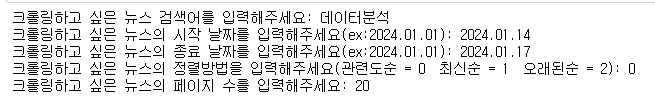  
이와 같이 크롤링 옵션을 입력합니다. 네이버 뉴스에 등록된 뉴스만 크롤링 하도록 설정되어 있습니다.

In [3]:
#데이터 저장
import pandas as pd
import sqlite3

# 데이터베이스에서 데이터 읽기
conn = sqlite3.connect('news_info.db')
query = "SELECT * FROM news_crawl"
df = pd.read_sql_query(query, conn)
conn.close()

# 데이터를 CSV 파일로 변환
csv_file_path = "news_data.csv"
df.to_csv(csv_file_path, index=False, encoding='utf-8-sig')

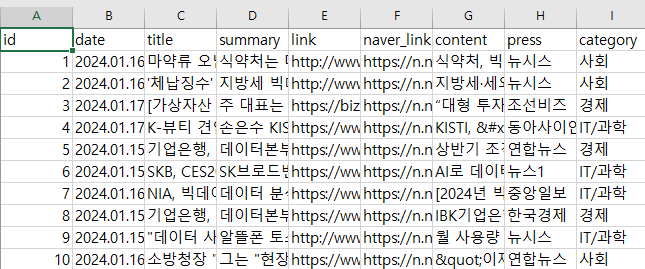  
CSV로 저장시 위와 같은 형태로 저장됩니다.

In [ ]:
#html + gpt api
from flask import Flask, request, jsonify, render_template
import sqlite3
import html
from openai import OpenAI
import os

app = Flask(__name__)

# API 키를 파일에서 읽기
with open('OPENAI_API_KEY.txt', 'r') as file:
    api_key = file.read().strip()
    
client = OpenAI(api_key=api_key)

def generate_gpt_content(news_content, summary_limit, title_limit, language, user_request):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"'{news_content}' 위 내용을 바탕으로 {language}로 개선된 뉴스본문을 작성해. 그리고 {summary_limit}자 이내의 요약과 {title_limit}자 이내의 제목도 생성해. 반드시 뉴스본문 앞에는 gpt_content: 를 요약 앞에는 gpt_summary: 를, 제목 앞에는 gpt_title: 을 붙여.{user_request}"
            },
        ]
    )
    return response.choices[0].message.content
# def generate_gpt_content(news_content):
#     response = client.chat.completions.create(
#         model="gpt-3.5-turbo",
#         messages=[
#             {"role": "system", "content": "You are a helpful assistant."},
#             {
#                 "role": "user",
#                 "content": f"'{news_content}' 위 내용을 바탕으로 한국어로 개선된 뉴스본문을 작성해. 그리고 50자 이내의 요약과 30자 이내의 제목도 생성해. 반드시 뉴스본문 앞에는 gpt_content: 를 요약 앞에는 gpt_summary: 를, 제목 앞에는 gpt_title: 을 붙여."
#             },
#         ]
#     )
#     return response.choices[0].message.content

@app.route('/')
def show_news():
    # 데이터베이스에서 뉴스 데이터를 가져옵니다.
    conn = sqlite3.connect('news_info.db')
    cur = conn.cursor()
    cur.execute("SELECT * FROM news_crawl")
    news_data = cur.fetchall()
    conn.close()

    # HTML 템플릿에 데이터를 직접 전달합니다.
    return render_template('news_template.html', news_data=news_data)

@app.route('/process', methods=['POST'])

def process():
    news_content = request.form['content']
    summary_limit = int(request.form.get('summary_limit', '50'))
    title_limit = int(request.form.get('title_limit', '30'))
    language = request.form.get('language', '한국어')  # 기본값은 한국어
    user_request = request.form.get('user_request', '')  # 기본값은 빈 문자열
    decoded_content = html.unescape(news_content)
    app.logger.info('Received content: %s', decoded_content)
    gpt_response = generate_gpt_content(decoded_content, summary_limit, title_limit, language, user_request)


    return jsonify({'gpt_result': gpt_response})

if __name__ == '__main__':
    app.run(debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [17/Jan/2024 15:33:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Jan/2024 15:33:15] "GET /static/style.css HTTP/1.1" 304 -


셀을 실행하면 http://127.0.0.1:5000 에 html이 표시됩니다.    

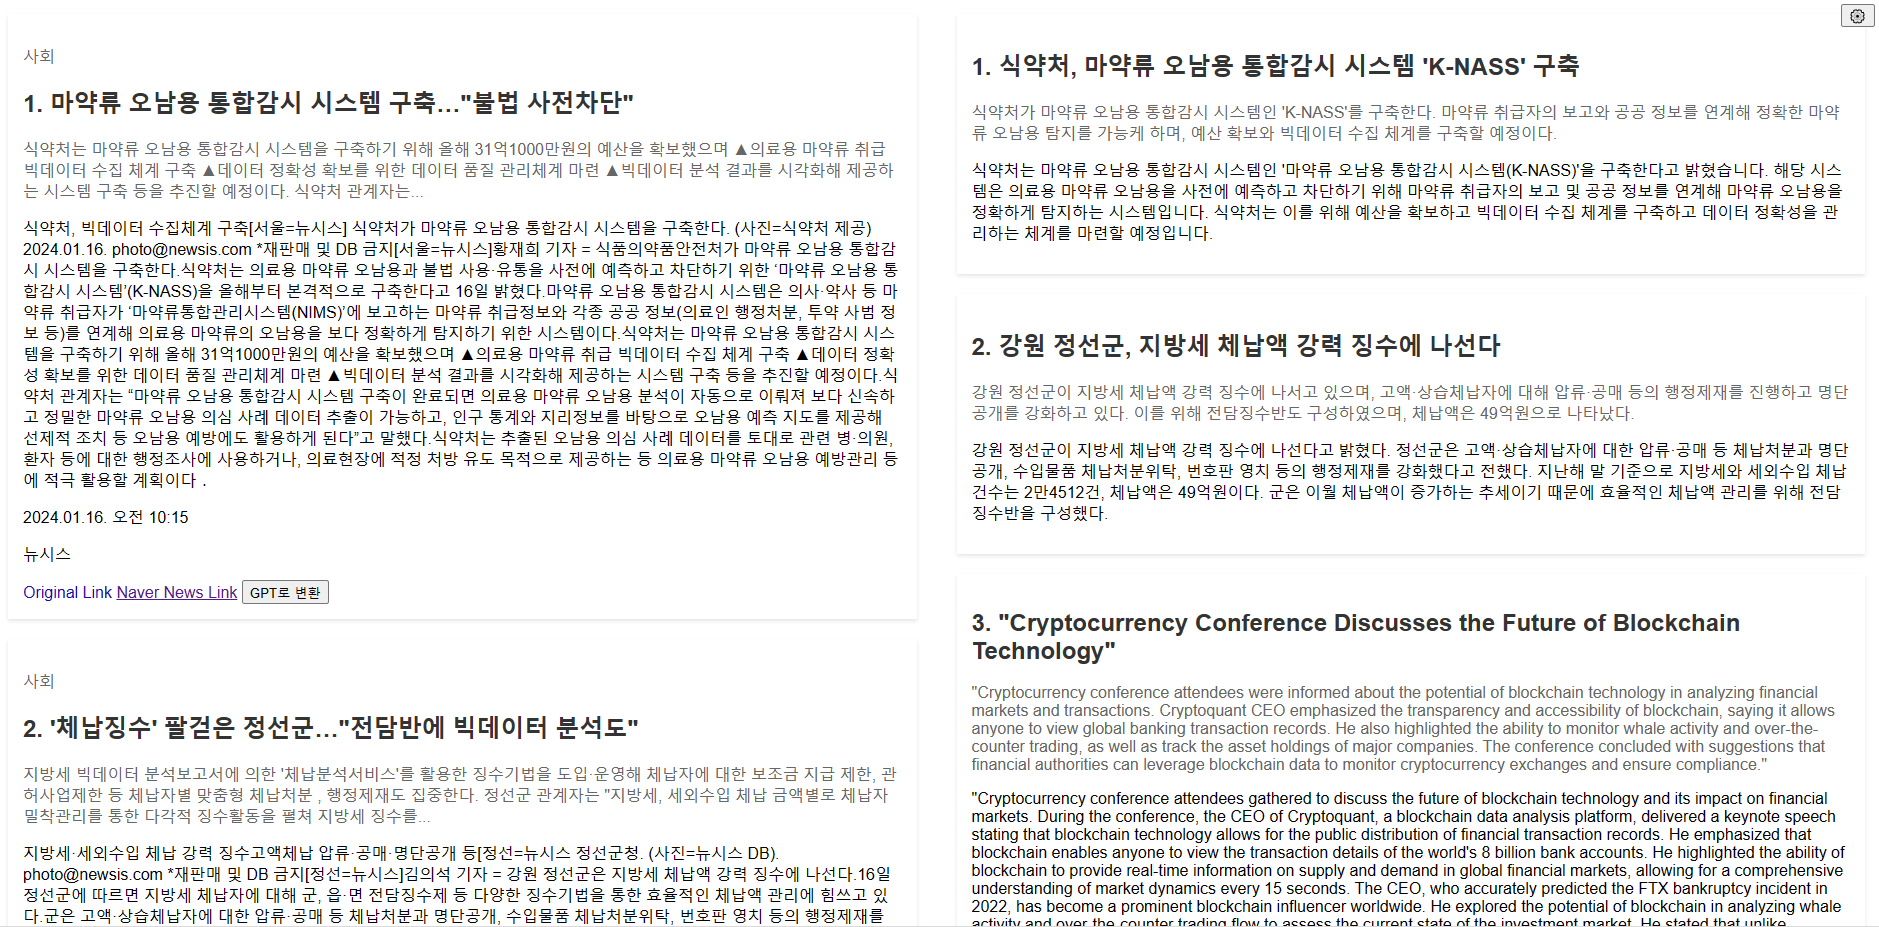

  
원본 뉴스 하단의 gpt로 변환 버튼을 누르면 왼쪽에 원본 뉴스, 오른쪽에는 gpt로 변환된 뉴스가 보여집니다.


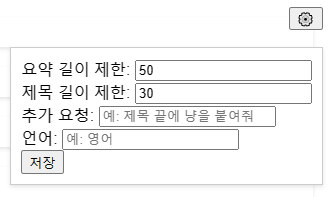   
페이지 우상단의 설정을 눌러 gpt로 변환시 옵션을 조정할 수 있습니다.   
단 길이 제한이 뉴스 내용에 비해 짧다고 gpt가 판단할 시 길이 제한을 무시하는 경향이 있습니다.   
또한 추가요청이 본문에 큰 영향을 끼치는 경우 요청이 무시될 수 있습니다.